In [ ]:
# ==============================================================================
# Part 1: Installation, Imports, and Environment Setup
# ==============================================================================
# Purpose: This is the first step of the project, where we install and import
#          all necessary libraries and set up the computing environment.
# Relevance: Lecture 4 - Basic setup for any deep learning project.

# Install the Hugging Face transformers library in the Colab environment.
# The '-q' flag makes the installation output less verbose.
!pip install transformers -q

import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os # Import the 'os' library to handle file paths and directories

# Import libraries (with the corrected import source for AdamW)
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW  # <-- Correction: AdamW is now imported from torch.optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm # Use tqdm for a nice progress bar

# --- Environment Setup ---
# Purpose: Set a fixed random seed to ensure that our results are reproducible
#          every time, which is crucial for validation and debugging.
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Purpose: Check for an available GPU and use it if possible.
#          This will significantly speed up model training.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ==============================================================================
# Part 2: Data Loading and Preprocessing
# ==============================================================================
# Purpose: Read the CSV files and clean the data into a format
#          that the model can use.
# Relevance: Lecture 3 - This is the starting point for supervised learning,
#          where we need labeled data.

print("\nLoading datasets...")
# Load data from the CSV files you uploaded to Colab
try:
    df_true = pd.read_csv("True.csv")
    df_fake = pd.read_csv("Fake.csv")
except FileNotFoundError:
    print("Error: Please make sure you have uploaded True.csv and Fake.csv to your Colab environment!")
    # Stop execution if files are not found
    raise

# Add a 'label' column to each dataframe -> 0 for Real News, 1 for Fake News
df_true['label'] = 0
df_fake['label'] = 1

# Concatenate the two dataframes and shuffle the result randomly
df = pd.concat([df_true, df_fake], ignore_index=True)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Core preprocessing step: Combine 'title' and 'text' into a single 'content' column.
# This allows the model to learn from the full context of both the headline and the article body.
df['content'] = df['title'] + ". " + df['text']

# Select the columns we need and drop any rows with missing values
df = df[['content', 'label']]
df.dropna(inplace=True)

print("Data loading and preprocessing complete!")
print(f"Total dataset size: {len(df)}")
print("Dataset preview:")
print(df.head())


Loading datasets...
Data loading and preprocessing complete!
Total dataset size: 44898
Dataset preview:
                                             content  label
0   BREAKING: GOP Chairman Grassley Has Had Enoug...      1
1   Failed GOP Candidates Remembered In Hilarious...      1
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...      1
3  California AG pledges to defend birth control ...      0
4  AZ RANCHERS Living On US-Mexico Border Destroy...      1


/tmp/ipython-input-2-1413015175.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [ ]:
# ==============================================================================
# Part 3: Tokenization (Preparing Data for BERT)
# ==============================================================================
# Purpose: Convert human-readable text into numerical sequences that a
#          computer can understand.
# Relevance: Lecture 5 - One of the core concepts of Transformer models.

print("\nStarting Tokenization...")
# Load the pre-trained BERT tokenizer from Hugging Face
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

input_ids = []
attention_masks = []
MAX_LENGTH = 128 # Set the maximum length for each text sequence

# Iterate through each article in the 'content' column
for text in df['content']:
    # The `encode_plus` function handles all preprocessing steps:
    # 1. Tokenize the text.
    # 2. Add special tokens `[CLS]` (start) and `[SEP]` (end).
    # 3. Map tokens to their numerical IDs.
    # 4. Pad or truncate the sentence to MAX_LENGTH.
    # 5. Create an attention mask to distinguish real tokens from padding.
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens=True,
                        max_length=MAX_LENGTH,
                        padding='max_length',
                        truncation=True,
                        return_attention_mask=True,
                        return_tensors='pt', # Return PyTorch Tensors
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['label'].values)

print("Tokenization complete!")
print(f"Input IDs Tensor Shape: {input_ids.shape}")


Starting Tokenization...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenization complete!
Input IDs Tensor Shape: torch.Size([44898, 128])


In [ ]:
# ==============================================================================
# Part 4: Create DataLoaders
# ==============================================================================
# Purpose: Split the data into training and validation sets, and create
#          DataLoaders to feed data to the model in batches.

# Split the dataset into 80% training and 20% validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, labels, random_state=SEED, test_size=0.2)
train_masks, val_masks, _, _ = train_test_split(attention_masks, labels, random_state=SEED, test_size=0.2)

BATCH_SIZE = 16 # Set the batch size

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data) # Sample batches randomly
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data) # Sample batches sequentially
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)
print("\nDataLoaders created!")


DataLoaders created!


In [ ]:
# ==============================================================================
# Part 5: Model Building and Training
# ==============================================================================
# Purpose: Load a pre-trained BERT model and fine-tune it on our specific task.
# Relevance: Lectures 4 & 5 - Implements transfer learning, forward/backward pass,
#          and the optimizer concepts.

# Load the pre-trained BertForSequenceClassification model, specifying 2 output labels
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)
model.to(device) # Move the model to the GPU

# Set up the optimizer (AdamW is commonly used for Transformers) and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
EPOCHS = 2 # Recommended to start with 2-4 epochs to avoid long training times

print(f"\nStarting model training for {EPOCHS} epochs...")

# Training loop
for epoch_i in range(0, EPOCHS):
    print(f"\n======== Epoch {epoch_i + 1} / {EPOCHS} ========")
    print('Training...')

    total_train_loss = 0
    model.train() # Set the model to training mode

    # Use tqdm for a progress bar
    for batch in tqdm(train_dataloader, desc="Training"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        # Forward Pass: Compute predictions and loss
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = result.loss

        total_train_loss += loss.item()

        # Backward Pass: Calculate gradients
        loss.backward()

        # Update Parameters: Adjust weights
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"  Average training loss: {avg_train_loss:.4f}")

    # --- Validation Phase ---
    print("Validating...")
    model.eval() # Set the model to evaluation mode
    total_eval_accuracy = 0

    for batch in tqdm(val_dataloader, desc="Validating"):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad(): # No need to calculate gradients during validation
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = result.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate accuracy
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        total_eval_accuracy += np.sum(pred_flat == labels_flat)

    avg_val_accuracy = total_eval_accuracy / len(val_data)
    print(f"  Validation Accuracy: {avg_val_accuracy:.4f}")

print("\nTraining complete!")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting model training for 2 epochs...

======== Epoch 1 / 2 ========
Training...


Training:   0%|          | 0/2245 [00:00<?, ?it/s]

  Average training loss: 0.0094
Validating...


Validating:   0%|          | 0/562 [00:00<?, ?it/s]

  Validation Accuracy: 0.9993

======== Epoch 2 / 2 ========
Training...


Training:   0%|          | 0/2245 [00:00<?, ?it/s]

  Average training loss: 0.0019
Validating...


Validating:   0%|          | 0/562 [00:00<?, ?it/s]

  Validation Accuracy: 0.9994

Training complete!



Performing final evaluation on the validation set...


Final Evaluation:   0%|          | 0/562 [00:00<?, ?it/s]


Classification Report:
               precision    recall  f1-score   support

Real News (0)       1.00      1.00      1.00      4311
Fake News (1)       1.00      1.00      1.00      4669

     accuracy                           1.00      8980
    macro avg       1.00      1.00      1.00      8980
 weighted avg       1.00      1.00      1.00      8980



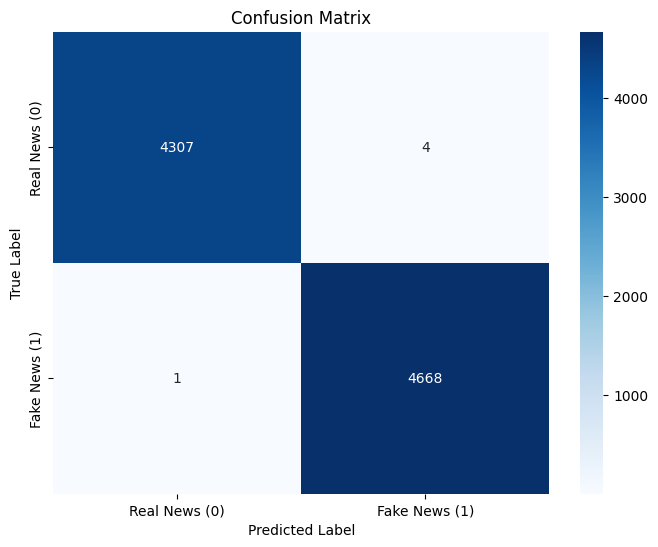

In [ ]:
# ==============================================================================
# Part 6: Model Evaluation
# ==============================================================================
# Purpose: Comprehensively evaluate the model's performance on the validation set,
#          generating a report and a confusion matrix.

print("\nPerforming final evaluation on the validation set...")
model.eval()

predictions, true_labels = [], []

for batch in tqdm(val_dataloader, desc="Final Evaluation"):
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

print("\nClassification Report:")
target_names = ['Real News (0)', 'Fake News (1)']
print(classification_report(true_labels, predictions, target_names=target_names))

# Plot the Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# ==============================================================================
# Part 6.5: Save the Fine-Tuned Model
# ==============================================================================
# Purpose: Save the trained model and tokenizer to a directory. This allows us
#          to reload it later for inference without having to retrain.
import os

# Create a directory to save the model
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"\nSaving model to {output_dir}")

# Use the save_pretrained method to save the model and tokenizer
# This saves the model weights and configuration file.
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("Model and Tokenizer saved successfully.")
# You can now find the model files in the 'model_save' folder in the Colab file browser.


Saving model to ./model_save/
Model and Tokenizer saved successfully.


In [ ]:
# ==============================================================================
# Part 7: Prediction and Visualization Functions
# ==============================================================================
# Purpose: Create reusable functions to predict the authenticity of a text and
#          visualize the result with a bar chart.

MAX_LENGTH = 128
target_names_map = {0: 'Real News', 1: 'Fake News'}

def visualize_prediction(probs):
    """Generates and displays a bar chart for the prediction probabilities."""
    labels = list(target_names_map.values())
    colors = ['#4CAF50', '#F44336'] # Green for Real, Red for Fake

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, probs, color=colors)
    plt.ylabel('Probability')
    plt.title('Prediction Probability')
    plt.ylim(0, 1.1)

    # Add percentage labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01, f'{height:.2%}', ha='center', va='bottom')

    plt.show()

def predict_news(text, model, tokenizer, device):
    """Processes a text input, gets a prediction, and visualizes it."""
    model.eval()
    encoded_text = tokenizer.encode_plus(
        text,
        max_length=MAX_LENGTH,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_text['input_ids'].to(device)
    attention_mask = encoded_text['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    # Get probabilities using softmax
    probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()[0]
    pred_label_idx = np.argmax(probs)
    pred_label = target_names_map[pred_label_idx]

    # Print the results
    print("-" * 30)
    print(f"Input Text: '{text}'")
    print(f"Prediction: {pred_label}")
    print(f"Probabilities -> Real News: {probs[0]:.2%}, Fake News: {probs[1]:.2%}")
    print("-" * 30)

    # Visualize the results
    visualize_prediction(probs)



======== Interactive Fake News Detector ========
You can now enter any news headline or text to check.
Type 'quit' or 'exit' to end the program.
Paste the news text here: SACRAMENTO, Calif. (Reuters) - California will increase the amount of money new parents can receive through the stateâ€™s paid family leave program under a bill signed on Monday by Democratic Governor Jerry Brown. The measure, passed last month by the Democratic-controlled state legislature, will increase the amount paid to new parents or people caring for a sick family member to as much as 70 percent of their regular income for the poorest workers, up from 55 percent, beginning in 2018. Those earning more will also get an increase in payments, to 60 percent from 55 percent. The legislation also eliminates a seven-day waiting period imposed on receiving the benefits. The program will apply to all parents who take time off from work to bond with a child within one year of birth, adoption or placement as a foster chil

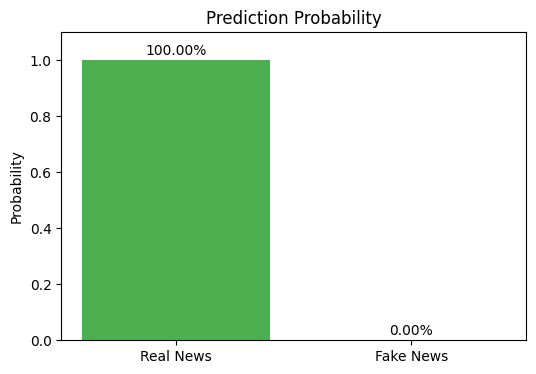

In [ ]:
# ==============================================================================
# Part 8: Interactive Prediction Loop
# ==============================================================================
# Purpose: Allow the user to freely input news headlines or text and get
#          instant predictions and visualizations from the model.

print("\n\n======== Interactive Fake News Detector ========")
print("You can now enter any news headline or text to check.")
print("Type 'quit' or 'exit' to end the program.")

user_input = input("Paste the news text here: ").strip()

if not user_input:
    print("⚠️ Error: Input cannot be empty!")
else:
    print("\nAnalyzing...")
    predict_news(user_input, model, tokenizer, device)